# LSTM

In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler, Normalizer
import seaborn as sns

In [2]:
df = pd.read_csv("../data/training_data.csv")
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,d_volatility,VIX
0,2017-01-03,2251.570068,2263.879883,2245.129883,2257.830078,2257.830078,3770530000,0.008328,12.85
1,2017-01-04,2261.600098,2272.820068,2261.600098,2270.750000,2270.750000,3764890000,0.004961,11.85
2,2017-01-05,2268.179932,2271.500000,2260.449951,2269.000000,2269.000000,3761820000,0.004872,11.67
3,2017-01-06,2271.139893,2282.100098,2264.060059,2276.979980,2276.979980,3339890000,0.007943,11.32
4,2017-01-09,2273.590088,2275.489990,2268.899902,2268.899902,2268.899902,3217610000,0.002899,11.56


In [3]:
#Separate dates for future plotting
train_dates = pd.to_datetime(df['Date'])
print(train_dates.tail(15)) #Check last few dates. 

1232   2021-11-23
1233   2021-11-24
1234   2021-11-26
1235   2021-11-29
1236   2021-11-30
1237   2021-12-01
1238   2021-12-02
1239   2021-12-03
1240   2021-12-06
1241   2021-12-07
1242   2021-12-08
1243   2021-12-09
1244   2021-12-10
1245   2021-12-13
1246   2021-12-14
Name: Date, dtype: datetime64[ns]


In [4]:
#Variables for training
cols = list(df)[5:9]
#Date and volume columns are not used in training. 
print(cols) 
df_for_training = df[cols].astype(float)

['Adj Close', 'Volume', 'd_volatility', 'VIX']


Normalizamos los datos

In [5]:
scaler = StandardScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)

### As required for LSTM networks, we require to reshape an input data into n_samples x timesteps x n_features. 
In this example, the n_features is 5. We will make timesteps = 14 (past days data used for training). 

In [6]:
#Empty lists to be populated using formatted training data
trainX = []
trainY = []

n_future = 16  # Number of days we want to look into the future based on the past days.
n_past = 32  # Number of past days we want to use to predict the future.

#Reformat input data into a shape: (n_samples x timesteps x n_features)
#In my example, my df_for_training_scaled has a shape (12823, 5)
#12823 refers to the number of data points and 5 refers to the columns (multi-variables).
for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])

trainX, trainY = np.array(trainX), np.array(trainY)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

trainX shape == (1200, 32, 4).
trainY shape == (1200, 1).


Modelo

In [36]:
def modelo_lstm(trainX,trainY,neuronas, capas, epocas, batch_size,validation_split):

    csv_logger = tf.keras.callbacks.CSVLogger('training.log', separator=',', append=False)

    model = tf.keras.models.Sequential()
    #Entrada
    model.add(tf.keras.layers.LSTM(neuronas ,activation='tanh', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
    model.add(tf.keras.layers.Dropout(0.2)) # regularizacion en las conexiones de entrada
    #second LSTM
    for i in range(capas):
        model.add(tf.keras.layers.LSTM(units=int(neuronas/2), activation='tanh', return_sequences = True))
        model.add(tf.keras.layers.Dropout(0.2))
    # Salida
    model.add(tf.keras.layers.Dense(trainY.shape[1]))
    model.compile(optimizer='adam', loss='mse')
    model.summary()

    #definir "early stopping" la loss de validacion no mejora en X épocas
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      patience=20,  #numero de epocas sin mejora
                                                      restore_best_weights = True)

    history = model.fit(trainX, trainY, epochs=epocas, batch_size=batch_size, validation_split=validation_split, verbose=1, callbacks=[early_stopping, csv_logger])

    plt.plot(history.history['loss'], label='Training loss')
    plt.plot(history.history['val_loss'], label='Validation loss')
    plt.ylabel("Error")
    plt.xlabel("Epocas")
    plt.legend()
    return model
    

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_27 (LSTM)              (None, 32, 64)            17664     
                                                                 
 dropout_17 (Dropout)        (None, 32, 64)            0         
                                                                 
 lstm_28 (LSTM)              (None, 32, 32)            12416     
                                                                 
 dropout_18 (Dropout)        (None, 32, 32)            0         
                                                                 
 dense_11 (Dense)            (None, 32, 1)             33        
                                                                 
Total params: 30,113
Trainable params: 30,113
Non-trainable params: 0
_________________________________________________________________
Epoch 1/36


2022-01-23 22:12:10.712493: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-23 22:12:10.937778: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-23 22:12:11.043068: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-23 22:12:11.161172: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-23 22:12:11.369566: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


134/135 [============================>.] - ETA: 0s - loss: 0.1380

2022-01-23 22:12:14.822346: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-23 22:12:14.896871: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-23 22:12:15.013802: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


135/135 [==============================] - 7s 27ms/step - loss: 0.1372 - val_loss: 0.3657
Epoch 2/36
135/135 [==============================] - 3s 23ms/step - loss: 0.0825 - val_loss: 0.2999
Epoch 3/36
135/135 [==============================] - 3s 22ms/step - loss: 0.0750 - val_loss: 0.2279
Epoch 4/36
135/135 [==============================] - 3s 23ms/step - loss: 0.0766 - val_loss: 0.1654
Epoch 5/36
135/135 [==============================] - 3s 22ms/step - loss: 0.0655 - val_loss: 0.2245
Epoch 6/36
135/135 [==============================] - 3s 22ms/step - loss: 0.0827 - val_loss: 0.2586
Epoch 7/36
135/135 [==============================] - 3s 22ms/step - loss: 0.1081 - val_loss: 2.2908
Epoch 8/36
135/135 [==============================] - 3s 23ms/step - loss: 0.1060 - val_loss: 0.4884
Epoch 9/36
135/135 [==============================] - 3s 22ms/step - loss: 0.0935 - val_loss: 0.3319
Epoch 10/36
135/135 [==============================] - 3s 22ms/step - loss: 0.0851 - val_loss: 0.4450


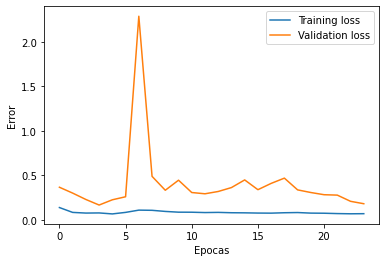

In [37]:
modelo = modelo_lstm(trainX, trainY, 64, capas=1,epocas=36, batch_size=8,validation_split=0.1)
# 64 neuronas, 1 capa, 36 epocas, batch_size=8, val_split= 0.1

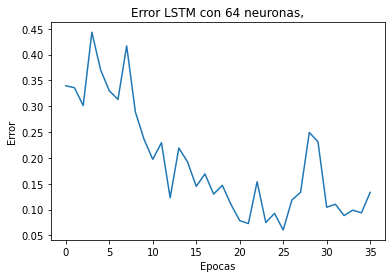

In [33]:
neuronas = 64
registro = pd.read_csv('training.log', sep=",")
plt.plot(registro["epoch"].values, registro["val_loss"].values)
plt.title("Error LSTM con %i neuronas," % (neuronas))
plt.ylabel("Error")
plt.xlabel("Epocas")
plt.show()

Predict

In [34]:
n_past = 16
n_days_for_prediction=15  #let us predict past 15 days

predict_period_dates = pd.date_range(list(train_dates)[-n_past], periods=n_days_for_prediction).tolist()
print(predict_period_dates)

[Timestamp('2021-11-22 00:00:00', freq='D'), Timestamp('2021-11-23 00:00:00', freq='D'), Timestamp('2021-11-24 00:00:00', freq='D'), Timestamp('2021-11-25 00:00:00', freq='D'), Timestamp('2021-11-26 00:00:00', freq='D'), Timestamp('2021-11-27 00:00:00', freq='D'), Timestamp('2021-11-28 00:00:00', freq='D'), Timestamp('2021-11-29 00:00:00', freq='D'), Timestamp('2021-11-30 00:00:00', freq='D'), Timestamp('2021-12-01 00:00:00', freq='D'), Timestamp('2021-12-02 00:00:00', freq='D'), Timestamp('2021-12-03 00:00:00', freq='D'), Timestamp('2021-12-04 00:00:00', freq='D'), Timestamp('2021-12-05 00:00:00', freq='D'), Timestamp('2021-12-06 00:00:00', freq='D')]


In [35]:
#Make prediction
prediction = modelo.predict(trainX[-n_days_for_prediction:]) #shape = (n, 1) where n is the n_days_for_prediction

#Perform inverse transformation to rescale back to original range
#Since we used 5 variables for transform, the inverse expects same dimensions
#Therefore, let us copy our values 5 times and discard them after inverse transform
prediction_copies = np.repeat(prediction, df_for_training.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copies)[:,0]

(Timestamp('2021-11-22 00:00:00'),)